<a href="https://colab.research.google.com/github/rahul13ramesh/modelzoo_continual/blob/main/modelzoo_minimal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A minimal implementation of Model Zoo:

This notebook is a minimal working example of [Model Zoo](https://arxiv.org/abs/2106.03027). It trains the Zoo in under 10 mins on 20 tasks from CIFAR100 constructed using the super-classes (Coarse-CIFAR100 benchmark).

In [ ]:
import numpy as np
import torch
import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torch.utils.data import DataLoader
from tqdm import tqdm
from tabulate import tabulate

In [1]:
dev = 'cuda'
EPISODES = 15

## Constructing Tasks from CIFAR100

We first define dataloaders for the Coarse-CIFAR100 task. We define a functions that fetches a set of tasks.

In [ ]:
# Download dataset
_ = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)
_ = torchvision.datasets.CIFAR100(root='./data', train=False, download=True)


coarse_cifar100 = [[4, 30, 55, 72, 95],  [1, 32, 67, 73, 91],
                   [54, 62, 70, 82, 92], [9, 10, 16, 28, 61],
                   [0, 51, 53, 57, 83],  [22, 39, 40, 86, 87],
                   [5, 20, 25, 84, 94],  [6, 7, 14, 18, 24],
                   [3, 42, 43, 88, 97],  [12, 17, 37, 68, 76],
                   [23, 33, 49, 60, 71], [15, 19, 21, 31, 38],
                   [34, 63, 64, 66, 75], [26, 45, 77, 79, 99],
                   [2, 11, 35, 46, 98],  [27, 29, 44, 78, 93],
                   [36, 50, 65, 74, 80], [47, 52, 56, 59, 96],
                   [8, 13, 48, 58, 90],  [41, 69, 81, 85, 89]]

task_names = ["Aq. Mammals", "Fish",
              "Flowers", "Food Container",
              "Fruits and Veggies", "Electrical Devices",
              "Household Furniture", "Insects", 
              "Large Carnivores", "Man-made Outdoor",
              "Natural Outdoor", "Omni-Herbivores",
              "Med. Mammals", "Invertebrates",
              "People", "Reptiles",
              "Small Mammals", "Trees",
              "Vehicles 1", "Vehicles 2"]

# Map each cifar100 label -> (task, task-label)
tmap, cmap = {}, {}
for tid, task in enumerate(coarse_cifar100):
    for lid, lab in enumerate(task):
        tmap[lab], cmap[lab] = tid, lid

def create_cifar100_task(tasks, train=True, shuffle=False, bs=256):
    # Don't use CIFAR10 mean/std to avoid leaking info 
    # Instead use (mean, std) of (0.5, 0.25)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25]),
    ])
    dataset = torchvision.datasets.CIFAR100(
        root='./data', train=train, download=False, transform=transform)
 
    # Select only those datapoints for our task
    task_labels = []
    for task_id in tasks:
        task_labels += coarse_cifar100[task_id]
    idx = np.where(np.isin(dataset.targets, task_labels))[0]
    
    dataset.targets = [(tmap[dataset.targets[j]], cmap[dataset.targets[j]]) for j in idx]
    dataset.data = dataset.data[idx]
    
    # Create dataloader. Set workers to 0, since too few batches
    dataloader = DataLoader(
        dataset, batch_size=bs, shuffle=shuffle,
        num_workers=0, pin_memory=True)
    
    return dataloader

# Create dataloaders for each task
train_loaders = []
test_loaders = []

for i in range(20):
    train_loaders.append(create_cifar100_task([i], train=True))
    test_loaders.append(create_cifar100_task([i], train=False))

Files already downloaded and verified
Files already downloaded and verified


We store the output_label for every task into one matrix. This makes is easier later on to compute the loss/accuracy on all tasks.

In [ ]:
all_targets = []

# Store the targets for each task (for faster computation later)
for i in range(20):
    all_targets.append([])
    for loader in [train_loaders[i], test_loaders[i]]:
        task_targets = []
        for dat, target in loader:
            task_targets.append(target[1].numpy())
        task_targets = np.concatenate(task_targets)
        all_targets[i].append(task_targets)      

## Building the Model Zoo

Every model in the Model Zoo is a small convolution network with 0.1M parameters. Even this sufficies for SOTA performance on continual learning benchmarks. 

In [ ]:
class SmallConv(nn.Module):
    # Small convolution network
    def __init__(self, channels=3, avg_pool=2, lin_size=320):
        super(SmallConv, self).__init__()
        self.conv1 = nn.Conv2d(channels, 80, kernel_size=3, bias=False)
        self.conv2 = nn.Conv2d(80, 80, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(80)
        self.conv3 = nn.Conv2d(80, 80, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(80)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(avg_pool)
        self.fc = nn.Linear(lin_size, 100)
        self.linsize = lin_size

        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x, tasks):
        x = self.conv1(x)
        x = self.maxpool(self.relu(x))
        x = self.conv2(x)
        x = self.maxpool(self.relu(self.bn2(x)))
        x = self.conv3(x)
        x = self.maxpool(self.relu(self.bn3(x)))
        x = x.view(-1, self.linsize)
        logits = self.fc(x)
        logits = logits.reshape(-1, 20, 5)
        # Select only relevant logits based on task
        logits = logits[torch.arange(logits.size(0)), list(tasks), :]
        return logits



We define functions that help us construct the Model Zoo, which perform the following operations:

1. Sample a set of tasks with high training loss
2. Train a model on these tasks
3. Add model to the zoo (in our case, we store all the outputs of this model instead)
4. Evaluate the zoo and compute the training loss of each task for the next iteration

In [ ]:
def process_dat(dat, target):
    # Helper function to push data to gpu
    dat = dat.to(dev)
    tasks, labels = target
    labels = labels.long().to(dev)
    tasks = tasks.long().to(dev)
    return dat, labels, tasks


def sample_task(train_losses, episode, bb):
    # Samples "bb" tasks to train on
    bb = min(bb, episode+1)

    if episode == 0:
        return [0]

    prob = (train_losses - np.mean(train_losses)) / np.mean(train_losses)
    prob = np.exp(prob).clip(0.0001, 1000)
    prob = prob / np.sum(prob)

    tasks = list(np.random.choice(episode, bb-1, replace=False, p=prob))
    tasks.append(episode) # Add the newest task to the list
    tasks = [int(t) for t in tasks]
    return tasks

def train_model(tasks, epochs):
    # Train a single model on the Model Zoo
    net = SmallConv()
    if dev != 'cpu':
        net.cuda()
    
    # No cosine-annlealing, fp16, larger batchs-size
    # This leads to worse accuraices, but leads to simpler or faster code
    mttask_loader = create_cifar100_task(tasks, shuffle=True, bs=32)
    optimizer = optim.SGD(net.parameters(), lr=0.01,momentum=0.9,
                          nesterov=True,weight_decay=0.00001)
    criterion = nn.CrossEntropyLoss()

    net.train()
    for ep in tqdm(range(epochs)):
        for dat, target in mttask_loader:
            optimizer.zero_grad()
            dat, labels, tasks = process_dat(dat, target)
            out = net(dat, tasks)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
    return net


def update_zoo(net, tasks, zoo_outputs):
    # Instead of storing the new network into the model zoo, we store all
    # outputs of the network for faster run-times
    criterion = nn.CrossEntropyLoss()
    net.eval()

    with torch.inference_mode():
        for tid in tasks:
            for idx, dataloader in enumerate([train_loaders[tid], test_loaders[tid]]):
                outputs = []
                for dat, target in dataloader:
                    dat, labels, tasks = process_dat(dat, target)
                    out = net(dat, tasks)
                    out = nn.functional.softmax(out, dim=1)
                    out = out.cpu().detach().numpy()
                    outputs.append(out)
                outputs = np.concatenate(outputs)
                zoo_outputs[tid][idx].append(outputs)


def evaluate_zoo(episode, zoo_outputs):
    # Evaluate the entire model zoo and all tasks seen until current episode
    criterion = nn.NLLLoss()
    met = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc":[]}

    for tid in range(episode+1):
        train_preds = np.mean(zoo_outputs[tid][0], axis=0)
        test_preds = np.mean(zoo_outputs[tid][1], axis=0)

        tr_loss = criterion(torch.Tensor(train_preds).log(),
                            torch.Tensor(all_targets[tid][0]).long())
        te_loss = criterion(torch.Tensor(test_preds).log(),
                            torch.Tensor(all_targets[tid][1]).long())
 
        met["train_loss"].append(tr_loss.item())
        met["test_loss"].append(te_loss.item())
        met["train_acc"].append((train_preds.argmax(1) == all_targets[tid][0]).mean())
        met["test_acc"].append((test_preds.argmax(1) == all_targets[tid][1]).mean())

    return met



In [ ]:
def run_zoo(bb=5, epochs=50):
    zoo_outputs = {}
    zoo_log = {}
    train_losses = []
    for ep in range(EPISODES):
        print("Epsisode " + str(ep))
        zoo_outputs[ep] = [[], []]  
        tasks = sample_task(train_losses, ep, bb)
    
        print("Training model on tasks: " + str(tasks))
        model = train_model(tasks, epochs)
        update_zoo(model, tasks, zoo_outputs)
        zoo_log[ep] = evaluate_zoo(ep, zoo_outputs)
        train_losses = zoo_log[ep]["train_loss"]
        print("Test Accuracies of the zoo:\n  %s\n" % str(zoo_log[ep]['test_acc']))
    return zoo_log

Finally, we train Model Zoo and Isolated. 5 epochs of training leads to under-trained models but it is sufficient to demonstrate the efficacy of Model Zoo. 

In [ ]:
zoo_log = run_zoo(bb=5, epochs=5)

Epsisode 0
Training model on tasks: [0]


100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


Test Accuracies of the zoo:
  [0.524]

Epsisode 1
Training model on tasks: [0, 1]


100%|██████████| 5/5 [00:13<00:00,  2.60s/it]


Test Accuracies of the zoo:
  [0.556, 0.7]

Epsisode 2
Training model on tasks: [1, 0, 2]


100%|██████████| 5/5 [00:19<00:00,  3.86s/it]


Test Accuracies of the zoo:
  [0.544, 0.714, 0.576]

Epsisode 3
Training model on tasks: [1, 2, 0, 3]


100%|██████████| 5/5 [00:26<00:00,  5.36s/it]


Test Accuracies of the zoo:
  [0.568, 0.732, 0.662, 0.666]

Epsisode 4
Training model on tasks: [2, 1, 0, 3, 4]


100%|██████████| 5/5 [00:32<00:00,  6.54s/it]


Test Accuracies of the zoo:
  [0.578, 0.734, 0.698, 0.704, 0.714]

Epsisode 5
Training model on tasks: [0, 1, 4, 3, 5]


100%|██████████| 5/5 [00:32<00:00,  6.52s/it]


Test Accuracies of the zoo:
  [0.578, 0.736, 0.698, 0.724, 0.754, 0.692]

Epsisode 6
Training model on tasks: [5, 2, 3, 4, 6]


100%|██████████| 5/5 [00:32<00:00,  6.48s/it]


Test Accuracies of the zoo:
  [0.578, 0.736, 0.68, 0.74, 0.764, 0.724, 0.658]

Epsisode 7
Training model on tasks: [5, 6, 4, 0, 7]


100%|██████████| 5/5 [00:32<00:00,  6.59s/it]


Test Accuracies of the zoo:
  [0.58, 0.736, 0.68, 0.74, 0.77, 0.724, 0.702, 0.718]

Epsisode 8
Training model on tasks: [1, 6, 0, 3, 8]


100%|██████████| 5/5 [00:32<00:00,  6.50s/it]


Test Accuracies of the zoo:
  [0.58, 0.742, 0.68, 0.736, 0.77, 0.724, 0.68, 0.718, 0.692]

Epsisode 9
Training model on tasks: [0, 5, 2, 6, 9]


100%|██████████| 5/5 [00:32<00:00,  6.49s/it]


Test Accuracies of the zoo:
  [0.59, 0.742, 0.694, 0.736, 0.77, 0.726, 0.69, 0.718, 0.692, 0.722]

Epsisode 10
Training model on tasks: [0, 2, 3, 8, 10]


100%|██████████| 5/5 [00:32<00:00,  6.42s/it]


Test Accuracies of the zoo:
  [0.588, 0.742, 0.706, 0.742, 0.77, 0.726, 0.69, 0.718, 0.708, 0.722, 0.766]

Epsisode 11
Training model on tasks: [0, 6, 10, 3, 11]


100%|██████████| 5/5 [00:32<00:00,  6.42s/it]


Test Accuracies of the zoo:
  [0.59, 0.742, 0.706, 0.738, 0.77, 0.726, 0.704, 0.718, 0.708, 0.722, 0.794, 0.64]

Epsisode 12
Training model on tasks: [3, 11, 0, 8, 12]


100%|██████████| 5/5 [00:32<00:00,  6.41s/it]


Test Accuracies of the zoo:
  [0.594, 0.742, 0.706, 0.746, 0.77, 0.726, 0.704, 0.718, 0.73, 0.722, 0.794, 0.676, 0.728]

Epsisode 13
Training model on tasks: [0, 5, 6, 2, 13]


100%|██████████| 5/5 [00:32<00:00,  6.45s/it]


Test Accuracies of the zoo:
  [0.596, 0.742, 0.702, 0.746, 0.77, 0.72, 0.702, 0.718, 0.73, 0.722, 0.794, 0.676, 0.728, 0.656]

Epsisode 14
Training model on tasks: [1, 0, 11, 12, 14]


100%|██████████| 5/5 [00:32<00:00,  6.44s/it]


Test Accuracies of the zoo:
  [0.582, 0.74, 0.702, 0.746, 0.77, 0.72, 0.702, 0.718, 0.73, 0.722, 0.794, 0.672, 0.72, 0.656, 0.388]



In [ ]:
isolated_log = run_zoo(bb=1, epochs=5)

Epsisode 0
Training model on tasks: [0]


100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Test Accuracies of the zoo:
  [0.55]

Epsisode 1
Training model on tasks: [1]


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Test Accuracies of the zoo:
  [0.55, 0.704]

Epsisode 2
Training model on tasks: [2]


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Test Accuracies of the zoo:
  [0.55, 0.704, 0.608]

Epsisode 3
Training model on tasks: [3]


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Test Accuracies of the zoo:
  [0.55, 0.704, 0.608, 0.688]

Epsisode 4
Training model on tasks: [4]


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Test Accuracies of the zoo:
  [0.55, 0.704, 0.608, 0.688, 0.688]

Epsisode 5
Training model on tasks: [5]


100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Test Accuracies of the zoo:
  [0.55, 0.704, 0.608, 0.688, 0.688, 0.69]

Epsisode 6
Training model on tasks: [6]


100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Test Accuracies of the zoo:
  [0.55, 0.704, 0.608, 0.688, 0.688, 0.69, 0.586]

Epsisode 7
Training model on tasks: [7]


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Test Accuracies of the zoo:
  [0.55, 0.704, 0.608, 0.688, 0.688, 0.69, 0.586, 0.708]

Epsisode 8
Training model on tasks: [8]


100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Test Accuracies of the zoo:
  [0.55, 0.704, 0.608, 0.688, 0.688, 0.69, 0.586, 0.708, 0.69]

Epsisode 9
Training model on tasks: [9]


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Test Accuracies of the zoo:
  [0.55, 0.704, 0.608, 0.688, 0.688, 0.69, 0.586, 0.708, 0.69, 0.724]

Epsisode 10
Training model on tasks: [10]


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Test Accuracies of the zoo:
  [0.55, 0.704, 0.608, 0.688, 0.688, 0.69, 0.586, 0.708, 0.69, 0.724, 0.694]

Epsisode 11
Training model on tasks: [11]


100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Test Accuracies of the zoo:
  [0.55, 0.704, 0.608, 0.688, 0.688, 0.69, 0.586, 0.708, 0.69, 0.724, 0.694, 0.614]

Epsisode 12
Training model on tasks: [12]


100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Test Accuracies of the zoo:
  [0.55, 0.704, 0.608, 0.688, 0.688, 0.69, 0.586, 0.708, 0.69, 0.724, 0.694, 0.614, 0.704]

Epsisode 13
Training model on tasks: [13]


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Test Accuracies of the zoo:
  [0.55, 0.704, 0.608, 0.688, 0.688, 0.69, 0.586, 0.708, 0.69, 0.724, 0.694, 0.614, 0.704, 0.658]

Epsisode 14
Training model on tasks: [14]


100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Test Accuracies of the zoo:
  [0.55, 0.704, 0.608, 0.688, 0.688, 0.69, 0.586, 0.708, 0.69, 0.724, 0.694, 0.614, 0.704, 0.658, 0.354]



## Evaluating Model Zoo

In [ ]:
def get_avg(run_log):
    # Avg. Accuracy at the end of all episodes
    return np.mean(run_log[EPISODES-1]['test_acc'])

def get_fwd(run_log):
    # Compute the learning accuracy (Reimer et al.) -- the accuracy when task 
    # is first seen.
    learning_acc = []
    for ep in range(EPISODES):
        learning_acc.append(run_log[ep]['test_acc'][-1])
    return np.mean(learning_acc), learning_acc

def get_bwd(run_log):
    # Compute the forgetting (max_acc - final acc)
    max_acc = []
    for task in range(EPISODES):
        maxval = 0.0
        for ep in range(task, EPISODES):
            maxval = max(run_log[ep]['test_acc'][task], maxval)
        max_acc.append(maxval)
    return np.mean(np.array(max_acc) - np.array(run_log[EPISODES-1]['test_acc']))

Model Zoo shows forward and backward transfer while showing minimal forgetting on all tasks. 

In [ ]:
table = []
table.append(["Avg task Acc at the end", get_avg(isolated_log), get_avg(zoo_log)])
table.append(["Learning accuracy (forward transfer)", get_fwd(isolated_log)[0], get_fwd(zoo_log)[0]])
table.append(["Forgetting (backward transfer)", get_bwd(isolated_log), get_bwd(zoo_log)])

print(tabulate(table, headers = ['metric', 'Isolated', 'zoo']))

metric                                  Isolated         zoo
------------------------------------  ----------  ----------
Avg task Acc at the end                    0.644  0.6908
Learning accuracy (forward transfer)       0.644  0.656
Forgetting (backward transfer)             0      0.00266667


In [ ]:
plt.style.use('seaborn-whitegrid')

def make_plot(run_log, title='Evolution of Task Accuracies'):
    for task in range(EPISODES):
        task_acc = []
        for ep in range(task, EPISODES):
            task_acc.append(run_log[ep]['test_acc'][task] * 100)
        plt.plot(range(task+1, EPISODES+1), task_acc, color=plt.cm.tab20(task))
        plt.scatter(range(task+1, EPISODES+1), task_acc, color=plt.cm.tab20(task))
    plt.title(title)
    plt.ylabel('Task Accuracy')
    plt.xlabel('Episode')
    plt.ylim([40, 90])
    plt.legend(task_names[:EPISODES], bbox_to_anchor = (1.05, 1.05), title='task')
    plt.show()

Model Zoo improves on past tasks. For example *Aq. Mammals* and *Fish* improve their accuracy with more episodes. It also has an improved ability to learn new tasks. For example *Household Furniture* has an accuracy ~60% for Isolated, while Model Zoo starts with an accuracy close to ~65%. Hence Model Zoo shows forward and backward transfer.

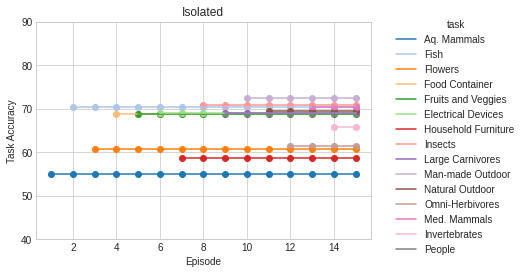

In [ ]:
make_plot(isolated_log, title='Isolated')

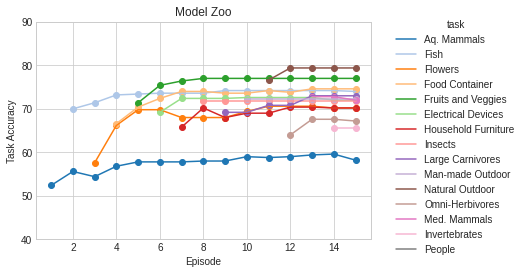

In [ ]:
make_plot(zoo_log, title='Model Zoo')